# Configure environment

In [1]:
import random
import time
import os
import datetime
import itertools
import math
import sys
from random import randint
import shutil
import gc

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
if IN_COLAB:
  COLAB_BASE_DIR = "/content/gdrive/MyDrive/Universidad/VIU/TFM/notebooks/"
  from google.colab import drive
  drive.mount('/content/gdrive/')
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'ConvLSTM'))
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'common'))

Mounted at /content/gdrive/


In [4]:
if IN_COLAB:
  if not os.path.exists("/data/masked_clouds.hdf5"):
    %mkdir -p /data
    shutil.copyfile(os.path.join(COLAB_BASE_DIR, "common/masked_clouds.hdf5"), "/data/masked_clouds.hdf5")

In [5]:
drive_comp_clouds_path = os.path.join(COLAB_BASE_DIR, 'common/processed_lstmcomparison.hdf5')
if IN_COLAB:
  if not os.path.exists("/data/mask_black_skygptdata.png"):
    !gdown 1OEqxhm4NrK1NDsQaBxuG22YY3K92SduH
    !gdown 1EDwJ7Q8gznhPCiv8Vnu1UZM5nQNrZJgw
    %mkdir -p /data
    %mv /content/*.png /data/
    %mv /content/*.h5 /data/
  if not os.path.exists("/data/video_prediction_dataset.hdf5") and not os.path.exists(drive_comp_clouds_path):
    !gdown 1fYtaFcGKSL8ykJFbewAFsFf9C4aW0DuV
    %mkdir -p /data
    %mv /content/*.hdf5 /data/

Downloading...
From: https://drive.google.com/uc?id=1OEqxhm4NrK1NDsQaBxuG22YY3K92SduH
To: /content/mask_black_skygptdata.png
100% 5.89k/5.89k [00:00<00:00, 19.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EDwJ7Q8gznhPCiv8Vnu1UZM5nQNrZJgw
To: /content/MultiUnetJoseBACKUP256weight_10_110_1_100_10.h5
100% 64.5M/64.5M [00:02<00:00, 23.7MB/s]


In [6]:
%%capture
%pip install torch torchvision torchmetrics h5py xarray matplotlib netcdf4 "tensorflow<=2.15.1" opencv-python

In [7]:
%pip freeze

absl-py==1.4.0
accelerate==0.34.2
aiohappyeyeballs==2.4.0
aiohttp==3.10.5
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.15
albumentations==1.4.14
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.18.0
asn1crypto==1.5.1
astropy==6.1.3
astropy-iers-data==0.2024.9.12.13.29.57
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.17.0
bigquery-magics==0.2.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
bqplot==0.12.43
branca==0.7.2
build==1.2.2
CacheControl==0.14.0
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
cftime==1.6.4
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
clarabel==0.9.0
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.19.0
cloudpickle==2.2.1
cmake==3.30.3
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0

In [8]:
import torch
import torchmetrics
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils.data as data
from torch.utils.data import DataLoader
import numpy as np
import h5py
import PIL.Image
from IPython.core import display as idisplay
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr
import tensorflow as tf
import cv2

import ConvLSTMmodels
if not IN_COLAB:
  sys.path.append('../common')
import common

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [10]:
if not IN_COLAB:
  common.set_memory_limit_if_not_limit(1.5)

# Load data

In [11]:
cwd = os.getcwd()
model_name_seg = "MaskedConvLSTM"
model_name_rnn = "ConvLSTM"
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,'data')
mask_path = os.path.join(data_folder,'mask_black_skygptdata.png')
data_path_masked = os.path.join(data_folder, 'masked_clouds.hdf5')
data_path_nomask = os.path.join(data_folder, 'video_prediction_dataset.hdf5')
output_path_seg = os.path.join(cwd, "save", f"{model_name_seg}.torch")
output_path_rnn = os.path.join(cwd, "save", f"{model_name_rnn}.torch")
comp_clouds_path = os.path.join(data_folder, 'processed_lstmcomparison.hdf5')
if IN_COLAB:
  output_path_seg = os.path.join(COLAB_BASE_DIR, "ConvLSTM", f"{model_name_seg}.torch")
  output_path_rnn = os.path.join(COLAB_BASE_DIR, "ConvLSTM", f"{model_name_rnn}.torch")

## Load models

In [12]:
def load_segconvlstm(path: str, device):
  N_VALUES_CLOUD_MASK = 5
  hidden_dims = [128, 128, 64]
  kernel_size = (3, 3)
  n_layers = 3
  clstm = ConvLSTMmodels.SegmentedConvLSTMNet(hidden_dims, kernel_size, n_layers, device, n_channels=N_VALUES_CLOUD_MASK, batch_normalization=True)
  clstm.load_state_dict(torch.load(path, map_location='cpu'))
  return clstm

In [13]:
def load_convlstm(path: str, device):
  hidden_dims = [128, 128, 64]
  kernel_size = (3, 3)
  n_layers = 3
  clstm = ConvLSTMmodels.RNNConvLSTM(hidden_dims, kernel_size, n_layers, device)
  clstm.load_state_dict(torch.load(path, map_location='cpu'))
  return clstm

In [14]:
seg_clstm = load_segconvlstm(output_path_seg, device)
rnn_clstm = load_convlstm(output_path_rnn, device)

<ipython-input-12-1dccd4add3e9>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clstm.load_state_dict(torch.load(path, map_location='cpu'))
<ipython-input-13-10b78b1d1608>:

In [15]:
cloud_segmenter_path = os.path.join(data_folder, "MultiUnetJoseBACKUP256weight_10_110_1_100_10.h5")
cloud_segmenter = tf.keras.models.load_model(cloud_segmenter_path)

## Load datasets

In [16]:
with h5py.File(data_path_masked, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)
    fds.close()

dss_masked = {}
for gname in group_names:
    dss_masked[gname] = xr.open_dataset(data_path_masked, engine='h5netcdf', group=gname, phony_dims='sort')

['test', 'trainval']


In [17]:
DOWNLOADED_BIGFILE = os.path.exists(data_path_nomask)
if DOWNLOADED_BIGFILE:
  with h5py.File(data_path_nomask, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)
    fds.close()

  dss_nomask = {}
  for gname in group_names:
    dss_nomask[gname] = xr.open_dataset(data_path_nomask, engine='h5netcdf', group=gname, phony_dims='sort')

## Prepare dataloaders

In [18]:
bs = 4
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.unpackbits(x, axis=1)),
    torch.from_numpy,
    transforms.Lambda(lambda x: torch.permute(x, (2, 0, 1)).float()),
])
test_dataset_masked = common.VideoDataset(dss_masked['test']['images_log'], dss_masked['test']['images_pred'], transform=transform, stack_videos=False, device=device)
test_loader_masked = DataLoader(test_dataset_masked, batch_size=bs, shuffle=False)

print(f"Number of videos: {len(test_dataset_masked.videos)}.")
print(f"Number of video batches: {len(test_loader_masked)}")
print(f"Size of video batches: {bs}.")


Number of videos: 4467.
Number of video batches: 1117
Size of video batches: 4.


In [19]:
mask_png = np.array(PIL.Image.open(mask_path).resize((64, 64)).getdata())
# Mask for size 64
print(mask_png.shape)
mask_to_black = (mask_png[:,3] > 127)
not_mask_to_black = (mask_png[:,3] <= 127)
print(mask_to_black.sum()) # alpha = 1 = black visible
print(not_mask_to_black.sum())
print(not_mask_to_black.sum()+mask_to_black.sum())
mask_to_black = mask_to_black.reshape((64, 64))
empty_mask = np.ones((64, 64, 3))
mask_to_black = np.where(np.expand_dims(mask_to_black, 2), empty_mask, empty_mask*0)

(4096, 4)
1418
2678
4096


In [20]:
bs = 4
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.where(mask_to_black, x*0, x)),
    transforms.ToPILImage(), # This already normalizes the image
    transforms.Resize(64),
    transforms.ToTensor(),
])
if DOWNLOADED_BIGFILE:
  test_dataset_nomask = common.VideoDataset(dss_nomask['test']['images_log'], dss_nomask['test']['images_pred'], transform=transform, stack_videos=False, device=device)
  test_loader_nomask = DataLoader(test_dataset_nomask, batch_size=bs, shuffle=False)

  print(f"Number of videos: {len(test_dataset_nomask.videos)}.")
  print(f"Number of video batches: {len(test_loader_nomask)}")
  print(f"Size of video batches: {bs}.")

# Process data

In [21]:
N_VALUES_CLOUD_MASK = 5

In [22]:
def resize_batch_vids(vids, size):
  vids = vids.permute((0, 1, 3, 4, 2))
  batch = torch.from_numpy(np.array([[cv2.resize(b[:,:,::-1], (size, size)) for b in vid] for vid in vids.cpu().numpy()]))
  return batch

In [23]:
def preproc_segment_clouds(batch, finalsize=64):
  ## Resized to 256 mandatory
  # And must be out of 256
  tf.keras.backend.clear_session()
  _ = gc.collect()
  shape = batch.shape
  batch = batch.flatten(0, 1).cpu().numpy()
  pred = np.array([cloud_segmenter(np.expand_dims(b, 0), training=False)[0].numpy() for b in batch])
  prediccion = np.argmax(pred, axis=3)
  prediccion = torch.unflatten(torch.from_numpy(prediccion), 0, shape[0:2])
  out = torch.from_numpy(np.eye(N_VALUES_CLOUD_MASK)[prediccion])
  out = torch.permute(out, (0, 1, 4, 2, 3))
  out = torch.from_numpy(np.array([transforms.functional.resize(v, finalsize).numpy() for v in out]))
  return out

In [24]:
def preproc_specific_comp(vids):
  vids[vids < 0] = 0
  vids = vids * 256
  vids = resize_batch_vids(vids, 256)
  out = preproc_segment_clouds(vids)
  out = torch.argmax(out, dim=2)
  out = torch.from_numpy(np.eye(N_VALUES_CLOUD_MASK)[out]).float().permute((0, 1, 4, 2, 3))
  return out

## Data visualizer

In [25]:
cmap = mcolors.ListedColormap(['black', 'cyan', 'yellow', 'white', 'blue'], 'CloudSegmenter')
def show_mask(img):
    labels_again = torch.argmax(img, dim=1).cpu()
    f = plt.figure(figsize=(9, 9), layout='tight')
    ncols = len(img)//4 if len(img) % 4 == 0 else len(img)//4 + 1
    axarr = f.subplots(4,4)
    for i in range(16):
      axarr[i//4][i%4].set_axis_off()
    for i in range(len(img)):
        axarr[i//4][i%4].imshow(labels_again[i], cmap=cmap, vmin=0, vmax=5)
    plt.show()

In [26]:
def show_nomask(img):
    img = img.permute(0, 2, 3, 1).cpu().numpy()[:,:,:,::-1]
    f = plt.figure(figsize=(9, 9), layout='tight')
    axarr = f.subplots(4,4)
    for i in range(16):
      axarr[i//4][i%4].set_axis_off()
    for i in range(len(img)):
        axarr[i//4][i%4].imshow(img[i])
    plt.show()

## Test data loading and visualization

0
torch.Size([4, 16, 5, 64, 64])


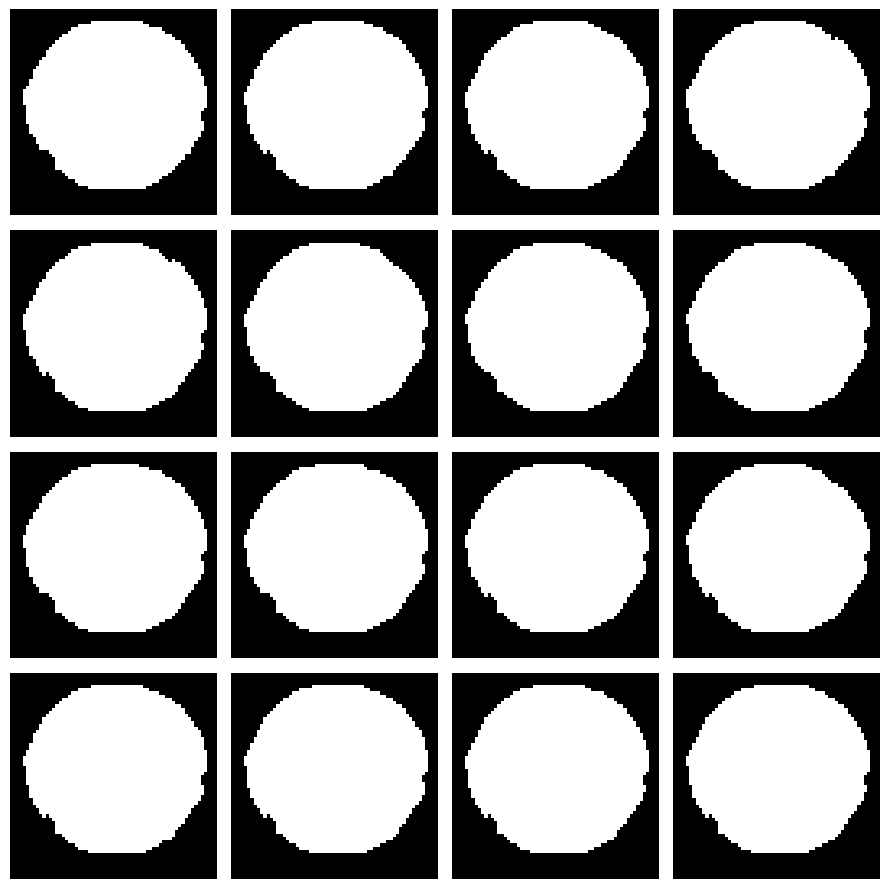

torch.Size([4, 15, 5, 64, 64])


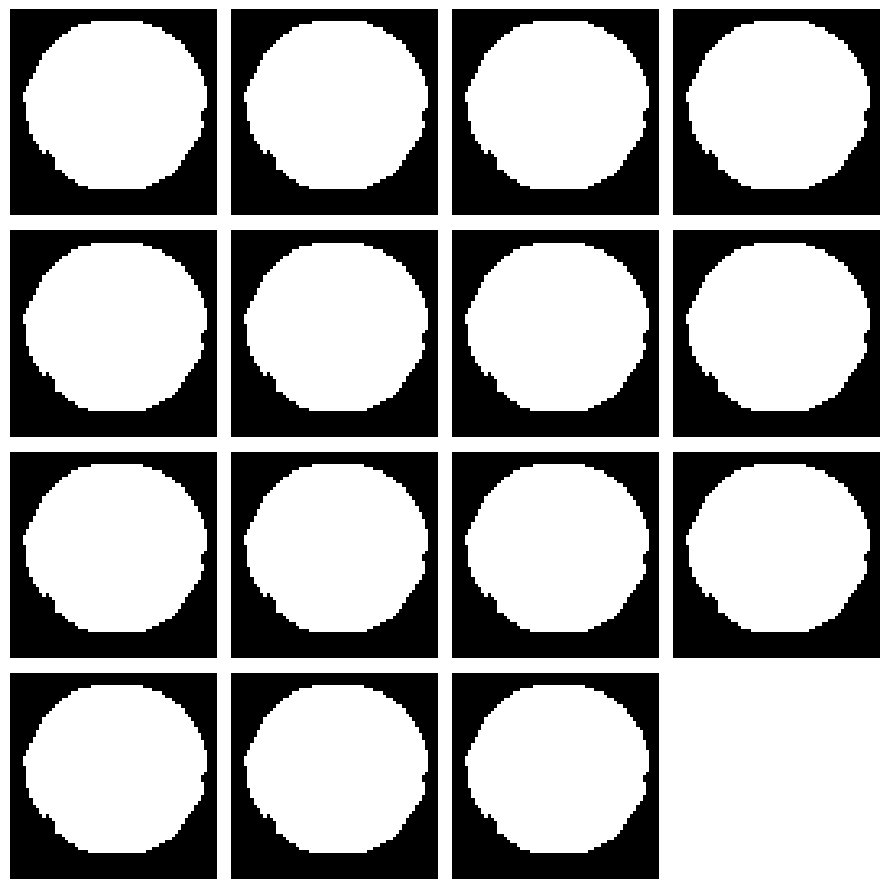

In [27]:
with torch.no_grad():
  for idx, (videos, targets) in enumerate(test_loader_masked):
    print(idx)
    print(videos.shape)
    show_mask(videos[1].data.cpu())
    pred = seg_clstm(videos, 15)
    print(pred.shape)
    show_mask(pred[1].data.cpu())
    break

In [28]:
if DOWNLOADED_BIGFILE:
  with torch.no_grad():
    for idx, (videos, targets) in enumerate(test_loader_nomask):
      id_video = 1
      print(idx)
      print(videos.shape)
      show_nomask(videos[id_video].data.cpu())
      vidmask = preproc_specific_comp(videos)
      print(vidmask.shape)
      show_mask(vidmask[id_video].data.cpu())
      pred = rnn_clstm(videos, 15)
      print(pred.shape)
      prshow = pred[id_video] # for showing
      prshow[prshow < 0] = 0 # for showing
      show_nomask(prshow.data.cpu())
      predmask = preproc_specific_comp(pred)
      print(predmask.shape)
      show_mask(predmask[id_video].data.cpu())
      break

In [29]:
print(pred[1].min())
print(pred[1].max())

tensor(1.0630e-19)
tensor(1.0000)


In [30]:
%mkdir save
if DOWNLOADED_BIGFILE:
  data = pred[1].data
  torchvision.utils.save_image(data.flip(dims=(1,)), 'save/sample_image.png')
  display(idisplay.Image('save/sample_image.png', width=700, unconfined=True))

## Process data and generate comparison files
(if necessary)

In [31]:
def process_and_store(path: str, test_loader_masked, test_loader_nomask, bs, seg_clstm, rnn_clstm):
  with h5py.File(path, 'w') as f:
    test_group = f.create_group('test')
    lendataset = len(test_dataset_nomask)
    num_log_frame = 16
    num_pred_frame = 15
    img_side_len = 64
    imagest_log_dset = test_group.create_dataset('images_log', shape=(lendataset, num_log_frame, img_side_len, img_side_len, 3), dtype=np.uint8)
    imagest_targ_dset = test_group.create_dataset('images_targ', shape=(lendataset, num_pred_frame, img_side_len, img_side_len, 3), dtype=np.uint8)
    maskst_log_dset = test_group.create_dataset('masks_log', shape=(lendataset, num_log_frame, img_side_len, img_side_len/8, N_VALUES_CLOUD_MASK), dtype=np.uint8)
    maskst_targ_dset = test_group.create_dataset('masks_targ', shape=(lendataset, num_pred_frame, img_side_len, img_side_len/8, N_VALUES_CLOUD_MASK), dtype=np.uint8)
    maskst_pred_seg_dset = test_group.create_dataset('masks_pred_seg', shape=(lendataset, num_pred_frame, img_side_len, img_side_len/8, N_VALUES_CLOUD_MASK), dtype=np.uint8)
    imagest_pred_noseg_dset = test_group.create_dataset('images_pred_noseg', shape=(lendataset, num_pred_frame, img_side_len, img_side_len, 3), dtype=np.uint8)
    maskst_pred_noseg_dset = test_group.create_dataset('masks_pred_noseg', shape=(lendataset, num_pred_frame, img_side_len, img_side_len/8, N_VALUES_CLOUD_MASK), dtype=np.uint8)
    with torch.no_grad():
      for idx, (videos, targets) in enumerate(test_loader_masked):
        mini = idx*bs
        maxi = (idx+1)*bs
        pred = seg_clstm(videos, 15)
        pred[pred < 0] = 0
        pred = torch.argmax(pred, dim=2)
        pred = torch.from_numpy(np.eye(N_VALUES_CLOUD_MASK)[pred.cpu()]).bool()
        pred = pred.permute((0, 1, 4, 2, 3))
        videos = videos.permute((0, 1, 3, 4, 2))
        targets = targets.permute((0, 1, 3, 4, 2))
        pred = pred.permute((0, 1, 3, 4, 2))
        maskst_log_dset[mini:maxi] = np.packbits(videos.bool().cpu().numpy(), axis=3)
        maskst_targ_dset[mini:maxi] = np.packbits(targets.bool().cpu().numpy(), axis=3)
        maskst_pred_seg_dset[mini:maxi] = np.packbits(pred.bool().cpu().numpy(), axis=3)
        if idx%10==0:
          print(f"{idx}/{len(test_loader_masked)}")
      for idx, (videos, targets) in enumerate(test_loader_nomask):
        mini = idx*bs
        maxi = (idx+1)*bs
        pred = rnn_clstm(videos, 15)
        predmask = preproc_specific_comp(pred)
        videos = videos.permute((0, 1, 3, 4, 2)) * 255
        targets = targets.permute((0, 1, 3, 4, 2)) * 255
        pred = pred.permute((0, 1, 3, 4, 2)) * 255
        predmask = predmask.permute((0, 1, 3, 4, 2))
        imagest_log_dset[mini:maxi] = videos.cpu().numpy().astype('uint8')
        imagest_targ_dset[mini:maxi] = targets.cpu().numpy().astype('uint8')
        imagest_pred_noseg_dset[mini:maxi] = pred.cpu().numpy()
        maskst_pred_noseg_dset[mini:maxi] = np.packbits(predmask.bool().cpu().numpy(), axis=3)
        if idx%10==0:
          print(f"{idx}/{len(test_loader_nomask)}")

In [32]:
if os.path.exists(drive_comp_clouds_path):
  print('Masked clouds file already exists. Copying...')
  shutil.copyfile(drive_comp_clouds_path, comp_clouds_path)
else:
  print('Masked clouds doesn\'t exist. Processing...')
  process_and_store(comp_clouds_path, test_loader_masked, test_loader_nomask, bs, seg_clstm, rnn_clstm)
  print('Saving in drive...')
  shutil.copyfile(comp_clouds_path, drive_comp_clouds_path)

Masked clouds file already exists. Copying...


In [33]:
if not os.path.exists(comp_clouds_path):
  print('comp_clouds_path file not available. Download it.')

with h5py.File(comp_clouds_path, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)
    fds.close()

dsm = {}
for gname in group_names:
    dsm[gname] = xr.open_dataset(comp_clouds_path, group=gname, engine="h5netcdf", phony_dims='sort')

['test']


## Load processed data

In [34]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.unpackbits(x, axis=1)),
    torch.from_numpy,
    transforms.Lambda(lambda x: torch.permute(x, (2, 0, 1)).float()),
])
btest_dataset_mask_gtruth = common.VideoDataset(dsm['test']['masks_log'], dsm['test']['masks_targ'], transform=transform, stack_videos=False, device=device)
btest_dataset_mask_preds = common.VideoDataset(dsm['test']['masks_pred_seg'], dsm['test']['masks_pred_noseg'], transform=transform, stack_videos=False, device=device)
btest_loader_mask_gtruth = DataLoader(btest_dataset_mask_gtruth, batch_size=8, shuffle=False)
btest_loader_mask_preds = DataLoader(btest_dataset_mask_preds, batch_size=8, shuffle=False)

In [35]:
transform = transforms.Compose([
    torch.from_numpy,
    transforms.Lambda(lambda x: torch.permute(x, (2, 0, 1))),
])
btest_dataset_img_gtruth = common.VideoDataset(dsm['test']['images_log'].astype('uint8'), dsm['test']['images_targ'].astype('uint8'), transform=transform, stack_videos=False, device=device)
btest_dataset_img_preds = common.VideoDataset(dsm['test']['images_log'].astype('uint8'), dsm['test']['images_pred_noseg'].astype('uint8'), transform=transform, stack_videos=False, device=device)
btest_loader_img_gtruth = DataLoader(btest_dataset_img_gtruth, batch_size=8, shuffle=False)
btest_loader_img_preds = DataLoader(btest_dataset_img_preds, batch_size=8, shuffle=False)

In [36]:
for idx, ((mlog, mtarg), (mseg, mnoseg), (ilog, itarg), (_, inoseg)) in enumerate(zip(btest_loader_mask_gtruth, btest_loader_mask_preds, btest_loader_img_gtruth, btest_loader_img_preds)):
  print(idx)
  print(mlog.shape)
  print(mtarg.shape)
  print(mseg.shape)
  print(mnoseg.shape)
  print(ilog.shape)
  print(itarg.shape)
  print(inoseg.shape)
  break

0
torch.Size([8, 16, 5, 64, 64])
torch.Size([8, 15, 5, 64, 64])
torch.Size([8, 15, 5, 64, 64])
torch.Size([8, 15, 5, 64, 64])
torch.Size([8, 16, 3, 64, 64])
torch.Size([8, 15, 3, 64, 64])
torch.Size([8, 15, 3, 64, 64])


0


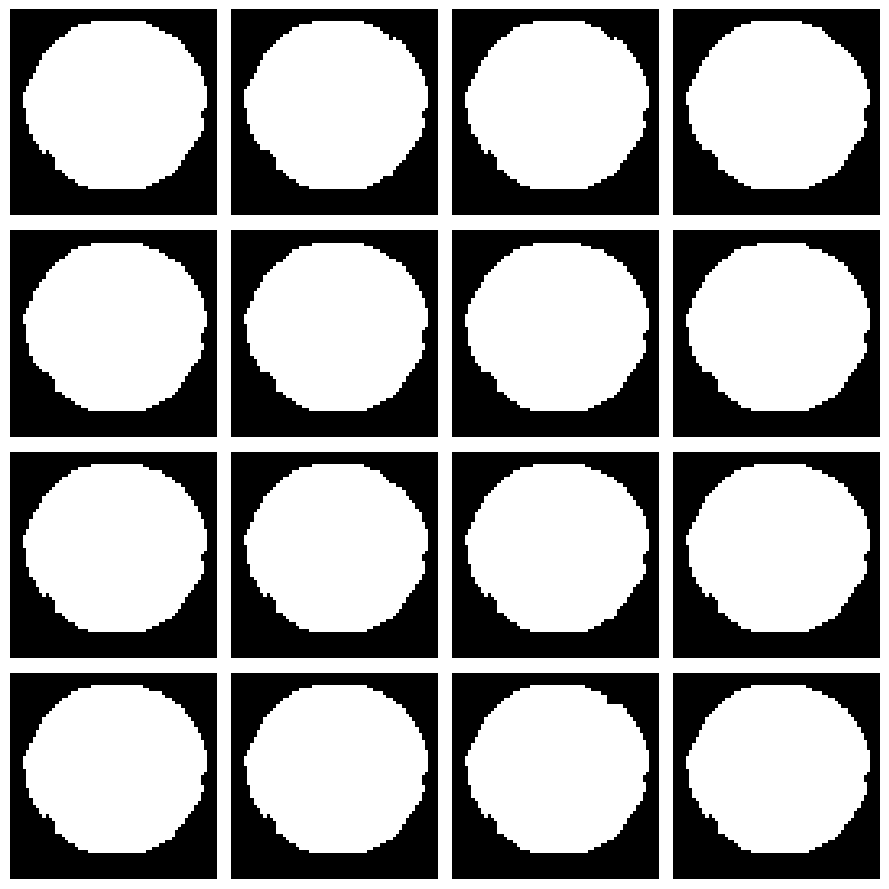

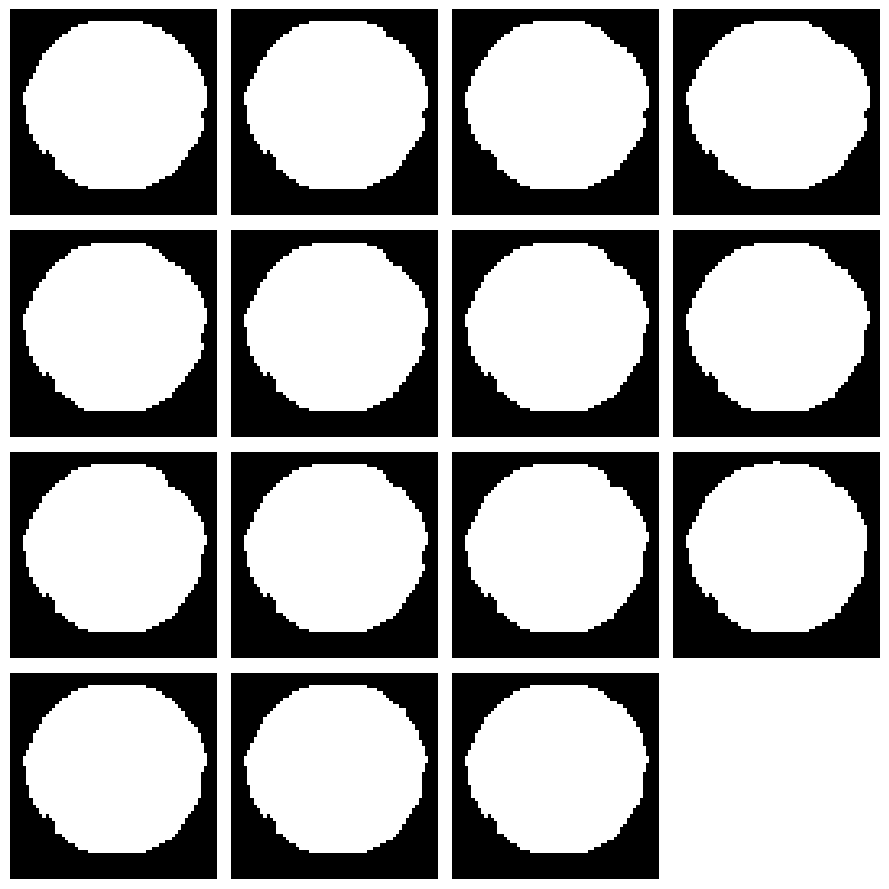

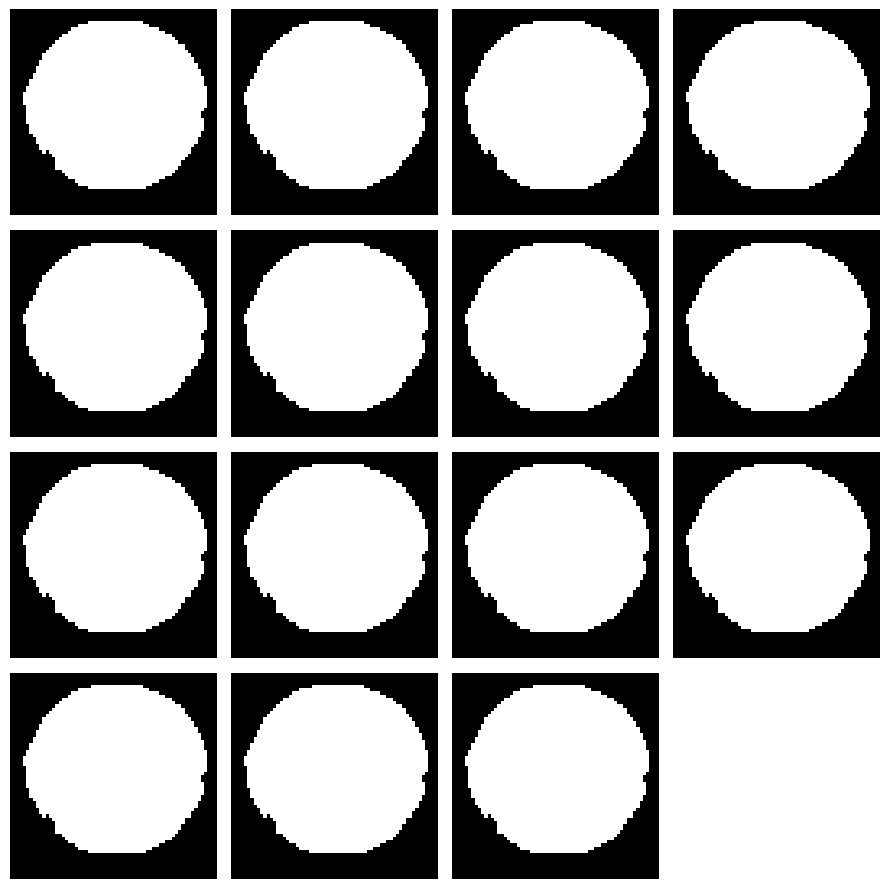

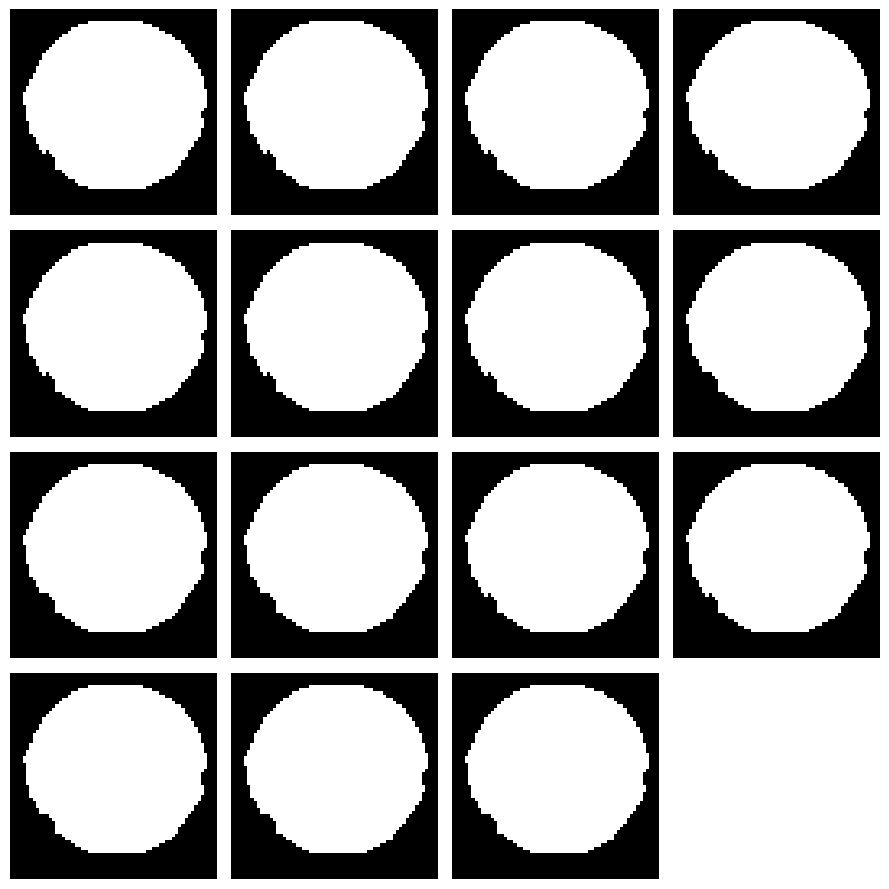

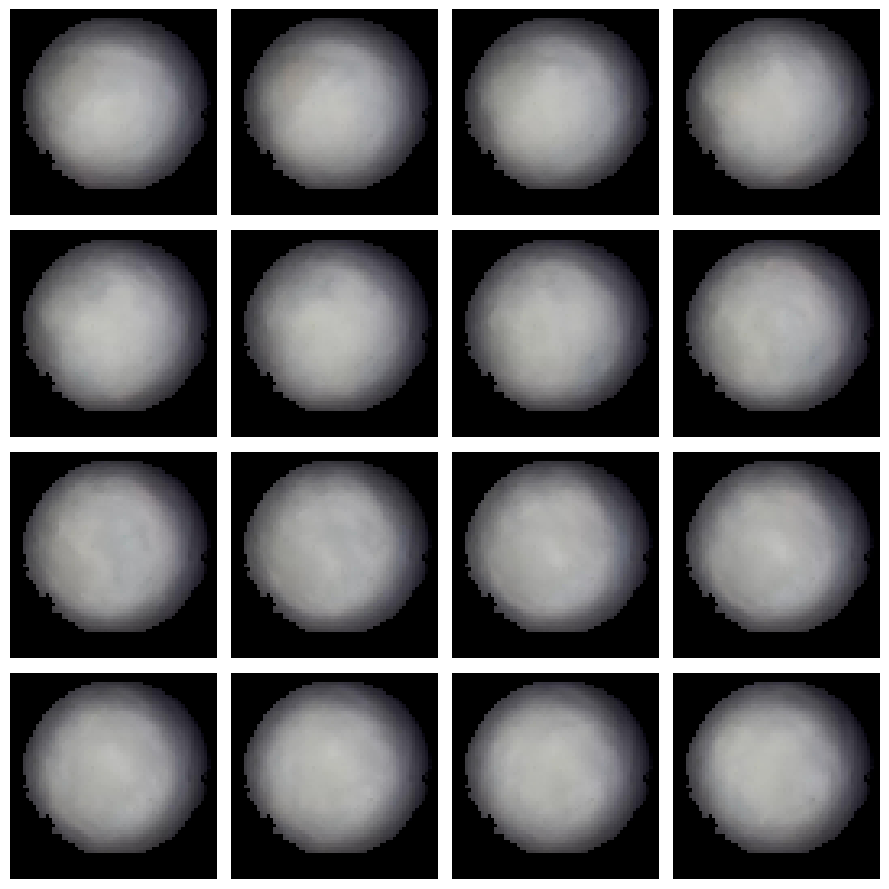

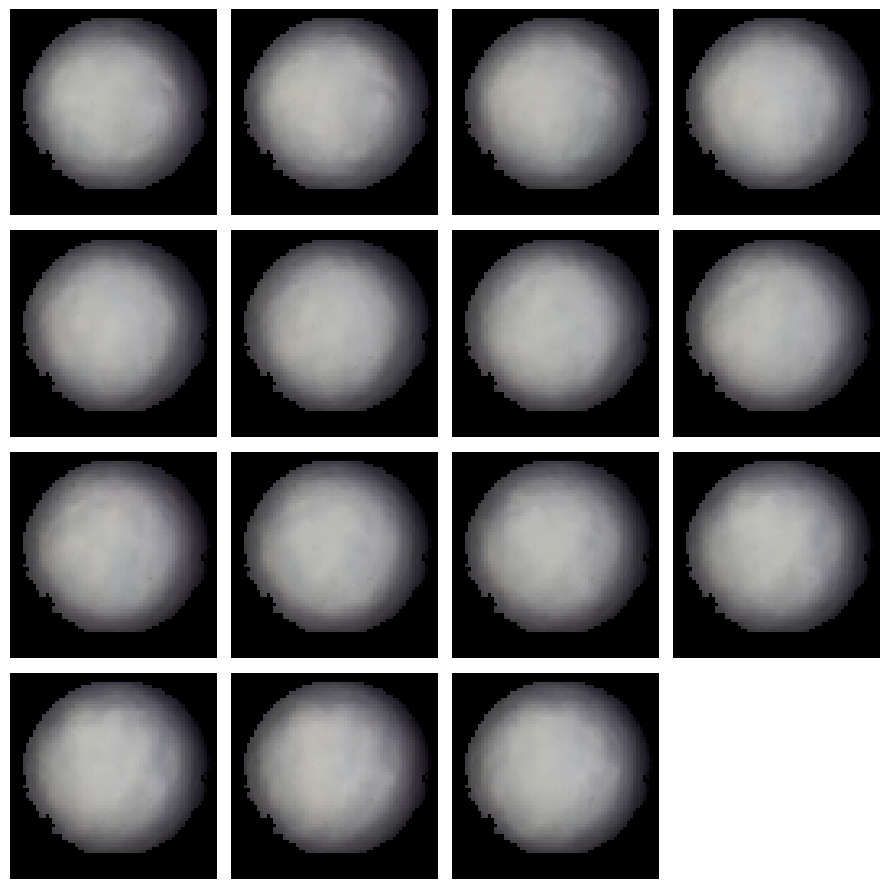

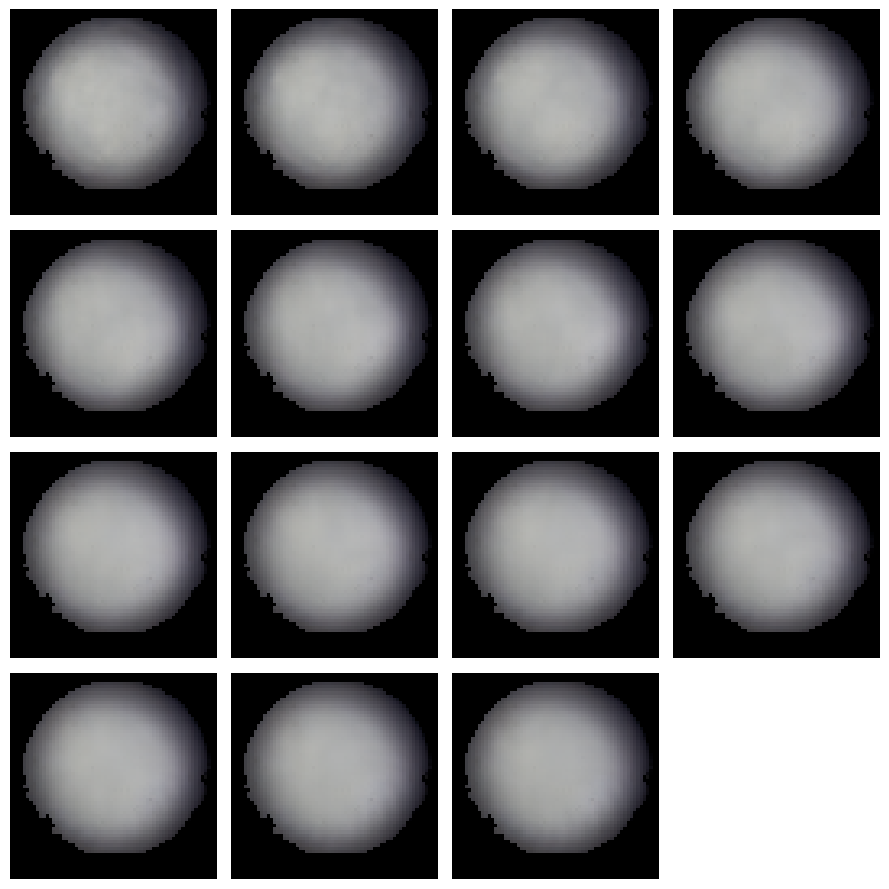

In [37]:
for idx, ((mlog, mtarg), (mseg, mnoseg), (ilog, itarg), (_, inoseg)) in enumerate(zip(btest_loader_mask_gtruth, btest_loader_mask_preds, btest_loader_img_gtruth, btest_loader_img_preds)):
  print(idx)
  showid = 3
  show_mask(mlog[showid])
  show_mask(mtarg[showid])
  show_mask(mseg[showid])
  show_mask(mnoseg[showid])
  show_nomask(ilog[showid])
  show_nomask(itarg[showid])
  show_nomask(inoseg[showid])
  break

In [60]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.unpackbits(x, axis=1)),
    torch.from_numpy,
    transforms.Lambda(lambda x: torch.permute(x, (2, 0, 1)).float()),
])
ids = [509*8, 510*8, 229*8, 310*8]
btest_dataset_mask_gtruth2 = common.VideoDataset([dsm['test']['masks_log'][i] for i in ids], [dsm['test']['masks_targ'][i] for i in ids], transform=transform, stack_videos=False, device=device)
btest_dataset_mask_preds2 = common.VideoDataset([dsm['test']['masks_pred_seg'][i] for i in ids], [dsm['test']['masks_pred_noseg'][i] for i in ids], transform=transform, stack_videos=False, device=device)
btest_loader_mask_gtruth2 = DataLoader(btest_dataset_mask_gtruth2, batch_size=1, shuffle=False)
btest_loader_mask_preds2 = DataLoader(btest_dataset_mask_preds2, batch_size=1, shuffle=False)
transform = transforms.Compose([
    torch.from_numpy,
    transforms.Lambda(lambda x: torch.permute(x, (2, 0, 1))),
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
btest_dataset_img_gtruth2 = common.VideoDataset([dsm['test']['images_log'][i].astype('uint8') for i in ids], [dsm['test']['images_targ'][i].astype('uint8') for i in ids], transform=transform, stack_videos=False, device=device)
btest_dataset_img_preds2 = common.VideoDataset([dsm['test']['images_log'][i].astype('uint8') for i in ids], [dsm['test']['images_pred_noseg'][i].astype('uint8') for i in ids], transform=transform, stack_videos=False, device=device)
btest_loader_img_gtruth2 = DataLoader(btest_dataset_img_gtruth2, batch_size=1, shuffle=False)
btest_loader_img_preds2 = DataLoader(btest_dataset_img_preds2, batch_size=1, shuffle=False)

In [40]:
def _show_vid_mask_data(vid_data):
  vid_data = vid_data[::2].flip(dims=(1,))
  voutput = torch.zeros(len(vid_data), 3, vid_data.size(-2), vid_data.size(-1), dtype=torch.float).to(device)
  for img_idx, img in enumerate(vid_data):
    img = img.unsqueeze(0)
    class_to_color = [torch.tensor([0, 0, 255]), torch.tensor([255, 255, 255]), torch.tensor([255, 255, 0]), torch.tensor([0, 255, 255]), torch.tensor([0, 0, 0])]
    output = torch.zeros(1, 3, vid_data.size(-2), vid_data.size(-1), dtype=torch.float).to(device)
    for class_idx, color in enumerate(class_to_color):
      mask = img[:,class_idx,:,:] == torch.max(img, dim=1)[0]
      mask = mask.unsqueeze(1) # should have shape 1, 1, 100, 100
      curr_color = color.reshape(1, 3, 1, 1).to(device)
      segment = mask*curr_color # should have shape 1, 3, 100, 100
      output += segment
    voutput[img_idx] = output.squeeze(0)
  torchvision.utils.save_image(voutput, 'save/real_image.png')
  display(idisplay.Image('save/real_image.png'))


def _show_vid_data(vid_data):
  vid_data = vid_data[::2].flip(dims=(1,))
  torchvision.utils.save_image(vid_data, 'save/real_image.png')
  display(idisplay.Image('save/real_image.png'))

0


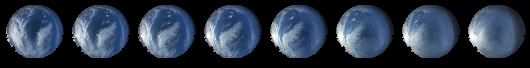

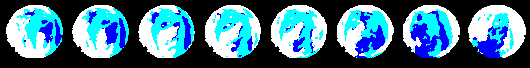

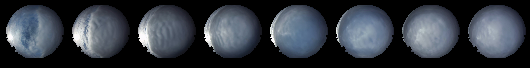

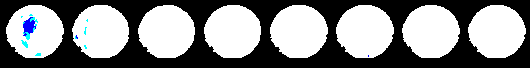

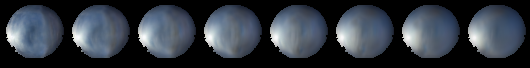

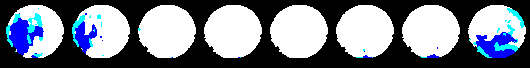

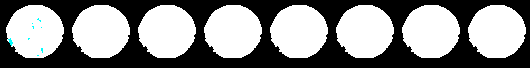

1


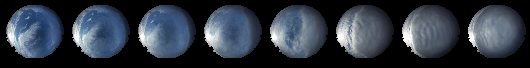

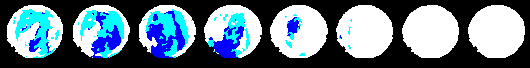

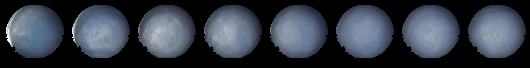

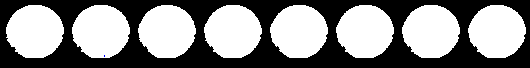

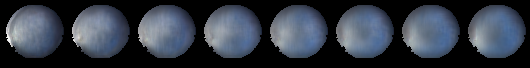

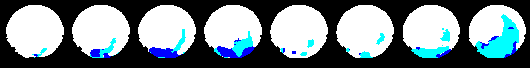

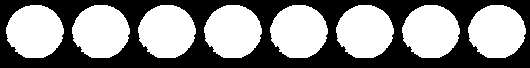

2


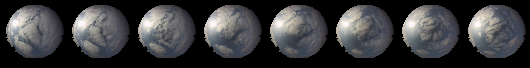

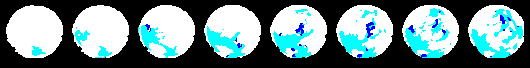

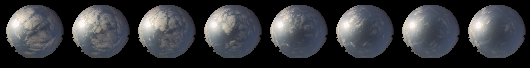

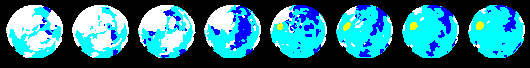

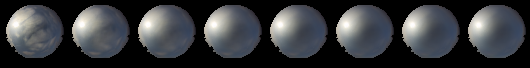

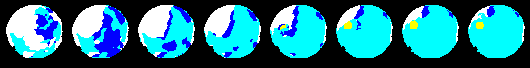

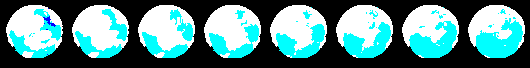

3


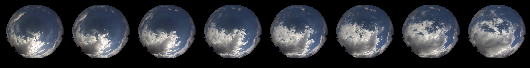

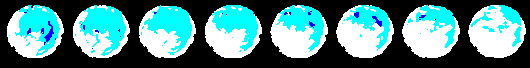

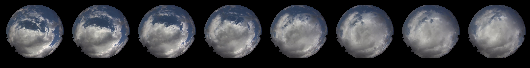

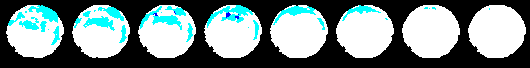

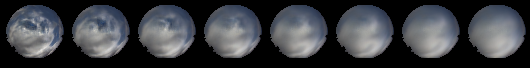

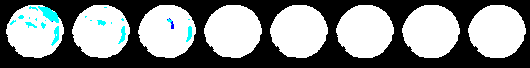

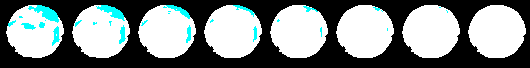

In [61]:
for idx, ((mlog, mtarg), (mseg, mnoseg), (ilog, itarg), (_, inoseg)) in enumerate(zip(btest_loader_mask_gtruth2, btest_loader_mask_preds2, btest_loader_img_gtruth2, btest_loader_img_preds2)):
  print(idx)
  showid = 0
  _show_vid_data(ilog[showid])
  _show_vid_mask_data(mlog[showid])
  _show_vid_data(itarg[showid])
  _show_vid_mask_data(mtarg[showid])
  _show_vid_data(inoseg[showid])
  _show_vid_mask_data(mnoseg[showid])
  _show_vid_mask_data(mseg[showid])

## Full data processing

In [ ]:
mse = nn.MSELoss()
_jaca = torchmetrics.JaccardIndex(task="multiclass", num_classes=5).to(device)
def jac(x, y):
  if len(x.shape) == 5:
    x = x.flatten(0, 1)
    y = y.flatten(0, 1)
  return _jaca(torch.argmax(x, axis=1), torch.argmax(y, axis=1))
_dice = torchmetrics.Dice().to(device)
dice = lambda x, y: _dice(torch.argmax(x, axis=len(x.shape)-3), torch.argmax(y, axis=len(y.shape)-3))
_cce = nn.CrossEntropyLoss()
def cce(x, y):
  if len(x.shape) == 5:
    x = x.permute(0, 2, 1, 3, 4)
    y = y.permute(0, 2, 1, 3, 4)
  return _cce(x, y)
loss_functions = [mse, cce, jac, dice]

losses_tsteps_seg = [[0 for _ in range(15)] for _ in range(len(loss_functions))]
losses_seg = [0 for _ in range(len(loss_functions))]
losses_tsteps_noseg = [[0 for _ in range(15)] for _ in range(len(loss_functions))]
losses_noseg = [0 for _ in range(len(loss_functions))]


for idx, ((mlog, mtarg), (mseg, mnoseg), (ilog, itarg), (_, inoseg)) in enumerate(zip(btest_loader_mask_gtruth, btest_loader_mask_preds, btest_loader_img_gtruth, btest_loader_img_preds)):
  with torch.no_grad():
    for i in range(15):
      for l, lossf in enumerate(loss_functions):
        lossp = lossf(mseg[:,i,:,:,:], mtarg[:,i,:,:,:])
        losses_tsteps_seg[l][i] += lossp.item()
        lossp = lossf(mnoseg[:,i,:,:,:], mtarg[:,i,:,:,:])
        losses_tsteps_noseg[l][i] += lossp.item()
    for l, lossf in enumerate(loss_functions):
      lossp = lossf(mseg, mtarg)
      losses_seg[l] += lossp.item()
      lossp = lossf(mnoseg, mtarg)
      losses_noseg[l] += lossp.item()
    lossp = None
    if idx % 10 == 0:
        to_print = (
            f"B[{idx+1}/{len(btest_loader_mask_gtruth)}]"
            f" AccLoss SEG: {np.mean(losses_seg)/bs:.4g} "
            f" AccLoss NOSEG: {np.mean(losses_noseg)/bs:.4g} "
        )
        print(to_print)

In [ ]:
print(losses_tsteps_seg)
print(losses_seg)
print(losses_tsteps_noseg)
print(losses_noseg)

In [ ]:
losses_tsteps_seg = [[7.454874813905917, 9.755070160143077, 11.464205092954217, 12.781872794352239, 13.967623150354484, 15.068790939025348, 16.037736279773526, 16.92899603320984, 17.766854160116054, 18.499906739860307, 19.21807487384649, 19.92029252933571, 20.582186217652634, 21.228328757279087, 21.875106132007204], [524.4385452270508, 530.1890345215797, 534.4618710875511, 537.7560414671898, 540.7204177379608, 543.4733366370201, 545.8956988453865, 548.1238488554955, 550.218493103981, 552.0511259436607, 553.84654545784, 555.6020920276642, 557.2568250894547, 558.8721803426743, 560.489122569561], [413.6933382451534, 391.4746353328228, 379.5398126542568, 372.3919829726219, 363.9442480504513, 359.2501694858074, 356.17979595065117, 352.7175269126892, 349.6954964995384, 345.01805794239044, 343.47522139549255, 341.3780339360237, 338.9311301112175, 336.1157431602478, 335.12173894047737], [540.3628132939339, 534.6123250126839, 530.3394877314568, 527.0453186035156, 524.0809428095818, 521.3280232548714, 518.9056599736214, 516.6775105595589, 514.5828654170036, 512.7502339482307, 510.95481365919113, 509.199269592762, 507.54453533887863, 505.92917889356613, 504.31223553419113]]
losses_seg = [16.1699946851586, 546.2263653874397, 335.46636936068535, 518.5750150084496]
losses_tsteps_noseg = [[8.874666490533855, 12.060774941375712, 14.571659551758785, 16.46487664739834, 18.028556601057062, 19.239343587250914, 20.299426617566496, 21.15990839531878, 21.890507339849137, 22.513114810804836, 23.186291842896026, 23.890544040419627, 24.578491622931324, 25.206103947071824, 25.85428913816577], [527.9880245923996, 535.953297317028, 542.2305080890656, 546.9635520577431, 550.8727514743805, 553.8997201323509, 556.5499262809753, 558.7011312842369, 560.5276271104813, 562.084145963192, 563.7670894265175, 565.5277215838432, 567.2475895881653, 568.8166189193726, 570.4370805025101], [404.05094879865646, 381.4935647249222, 367.5211324393749, 359.8688753545284, 353.8031334578991, 350.2426617741585, 346.5017255246639, 342.45473742485046, 341.1630966216326, 336.36606231331825, 334.24400812387466, 330.32979841530323, 326.6398458778858, 323.487623244524, 321.48920276761055], [536.8133341670036, 528.8480631709099, 522.570851624012, 517.8378092646599, 513.9286091923714, 510.9016418457031, 508.2514343261719, 506.10022991895676, 504.273732483387, 502.7172139286995, 501.0342712402344, 499.2736409306526, 497.55377197265625, 495.9847412109375, 494.36427813768387]]
losses_noseg = [19.85457052208949, 555.4378058314323, 321.4875625669956, 509.3635747432709]
losses_names = ['MSE', 'Cross Entropy', 'Jaccard Index', 'Dice Coefficient']

In [ ]:
n_vidba = 559
losses_tsteps_seg = np.array(losses_tsteps_seg)/n_vidba
losses_seg = np.array(losses_seg)/n_vidba
losses_tsteps_noseg = np.array(losses_tsteps_noseg)/n_vidba
losses_noseg = np.array(losses_noseg)/n_vidba

In [ ]:
print(losses_tsteps_seg)
print(losses_seg)
print(losses_tsteps_noseg)
print(losses_noseg)

In [ ]:
for lstes, lstens, name in zip(losses_tsteps_seg, losses_tsteps_noseg, losses_names):
  plt.plot(range(1, 16), lstes, '-o', label='MaskedConvLSTM')
  plt.plot(range(1, 16), lstens, '-o', label='ConvLSTM')
  plt.xlabel('Time step (min)')
  plt.ylabel(name)
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
for idx, ((mlog, mtarg), (mseg, mnoseg), (ilog, itarg), (_, inoseg)) in enumerate(zip(btest_loader_mask_gtruth, btest_loader_mask_preds, btest_loader_img_gtruth, btest_loader_img_preds)):
  if idx % 50 == 0:
    print(f"{idx}/{len(btest_loader_mask_gtruth)}")
    show_nomask(ilog[0])
    show_nomask(itarg[0])
    show_mask(mtarg[0])
    show_mask(mseg[0])
    show_nomask(inoseg[0])
    show_mask(mnoseg[0])

In [ ]:
print(f"MaskedConvLSTM total acc loss: {loss_seg}")
print(f"MaskedConvLSTM mean loss: {loss_seg/(bs*len(btest_loader_mask_gtruth))}")
print(f"Regular ConvLSTM total acc loss: {loss_noseg}")
print(f"Regular ConvLSTM mean loss: {loss_noseg/(bs*len(btest_loader_mask_gtruth))}")